In [1]:
import pandas as pd
import numpy as np
import os
import os.path as op
import copy
import numpy.random as rd

In [2]:
path = '../../data/kaggle-titanic'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
setNames = ['train.csv','test.csv']
data = []
for sn in setNames:
    data.append( pd.read_csv(op.join(path,sn)))
    print(data[-1].head())
    print(data[-1].info())

../../data/kaggle-titanic/train_label.csv
../../data/kaggle-titanic/test_RescaleClean.csv
../../data/kaggle-titanic/train_RescaleClean.csv
../../data/kaggle-titanic/test.csv
../../data/kaggle-titanic/submission.csv
../../data/kaggle-titanic/train.csv
../../data/kaggle-titanic/significantFeatures.txt
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch           

In [3]:
for ds in data:
    series = ds['Cabin'].copy()
    ds['CabinTag'] = 'X'
    ks = []
    for i, k in enumerate(series):
        if type(k)==str:
            ks.append(k[0])
            ds.loc[i,'CabinTag'] = k[0]

    nks = pd.Series(ks).unique()
    print(nks)

['C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
['B' 'E' 'A' 'C' 'D' 'F' 'G']


In [4]:
series = data[0]['Ticket'].copy()
ks = []
for d in series.dropna():
    print(d)
    ks.append(d[0])

A/5 21171
PC 17599
STON/O2. 3101282
113803
373450
330877
17463
349909
347742
237736
PP 9549
113783
A/5. 2151
347082
350406
248706
382652
244373
345763
2649
239865
248698
330923
113788
349909
347077
2631
19950
330959
349216
PC 17601
PC 17569
335677
C.A. 24579
PC 17604
113789
2677
A./5. 2152
345764
2651
7546
11668
349253
SC/Paris 2123
330958
S.C./A.4. 23567
370371
14311
2662
349237
3101295
A/4. 39886
PC 17572
2926
113509
19947
C.A. 31026
2697
C.A. 34651
CA 2144
2669
113572
36973
347088
PC 17605
2661
C.A. 29395
S.P. 3464
3101281
315151
C.A. 33111
CA 2144
S.O.C. 14879
2680
1601
348123
349208
374746
248738
364516
345767
345779
330932
113059
SO/C 14885
3101278
W./C. 6608
SOTON/OQ 392086
19950
343275
343276
347466
W.E.P. 5734
C.A. 2315
364500
374910
PC 17754
PC 17759
231919
244367
349245
349215
35281
7540
3101276
349207
343120
312991
349249
371110
110465
2665
324669
4136
2627
STON/O 2. 3101294
370369
11668
PC 17558
347082
S.O.C. 14879
A4. 54510
237736
27267
35281
2651
370372
C 17369
2668
3470

In [5]:
# fix missing data in training set
train_data = data[0]
mean = train_data["Age"].median()
std = train_data["Age"].std()

rand_age = rd.randint(mean-std, mean+std, size = 177)
age_slice = train_data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
train_data["Age"] = age_slice

train_data["Embarked"].fillna(value="C", inplace=True)
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
CabinTag         0
dtype: int64


In [6]:
# fix missing data in test set
test_data = data[1]
mean = test_data["Age"].median()
std = test_data["Age"].std()

rand_age = rd.randint(mean-std, mean+std, size = 86)
age_slice = test_data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
test_data["Age"] = age_slice
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)

print(test_data.isnull().sum())
print(test_data.head())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
CabinTag         0
dtype: int64
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked CabinTag  
0  34.5      0      0   330911   7.8292   NaN        Q        X  
1  47.0      1      0   363272   7.0000   NaN        S        X  
2  62.0      0      0   240276   9.6875   NaN        Q        X  
3  27.0      0

In [7]:
def extractTitle(X):
    
    title = []
    for n in X['Name']:
        
        if 'Mr.' in n:
            title.append(0)
        elif 'Mrs' in n:
            title.append(1)
        elif ('Miss.' or 'Ms.' or 'Mme') in n:
            title.append(2)
        elif 'Master' in n:
            title.append(3)
        elif ('Dr' or 'Rev' or 'Col' or 'Mlle' or 'Major' or 'Capt') in n:
            title.append(4)
        else:
            title.append(5)
            
    X['Title'] = title

extractTitle(train_data)
extractTitle(test_data)
# prepare training sessions/map categorial data to numerics
genders = {"male":0, "female":1}
train_data["Sex"] = train_data["Sex"].map(genders)
test_data["Sex"] = test_data["Sex"].map(genders)

ports = {"S":0, "C":1, "Q":2}
train_data["Embarked"] = train_data["Embarked"].map(ports)
test_data["Embarked"] = test_data["Embarked"].map(ports)

#cabins= {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'X':8}
cabins= {'A':0, 'B':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'T':0, 'X':1}
train_data["CabinTag"] = train_data["CabinTag"].map(cabins)
test_data["CabinTag"] = test_data["CabinTag"].map(cabins)

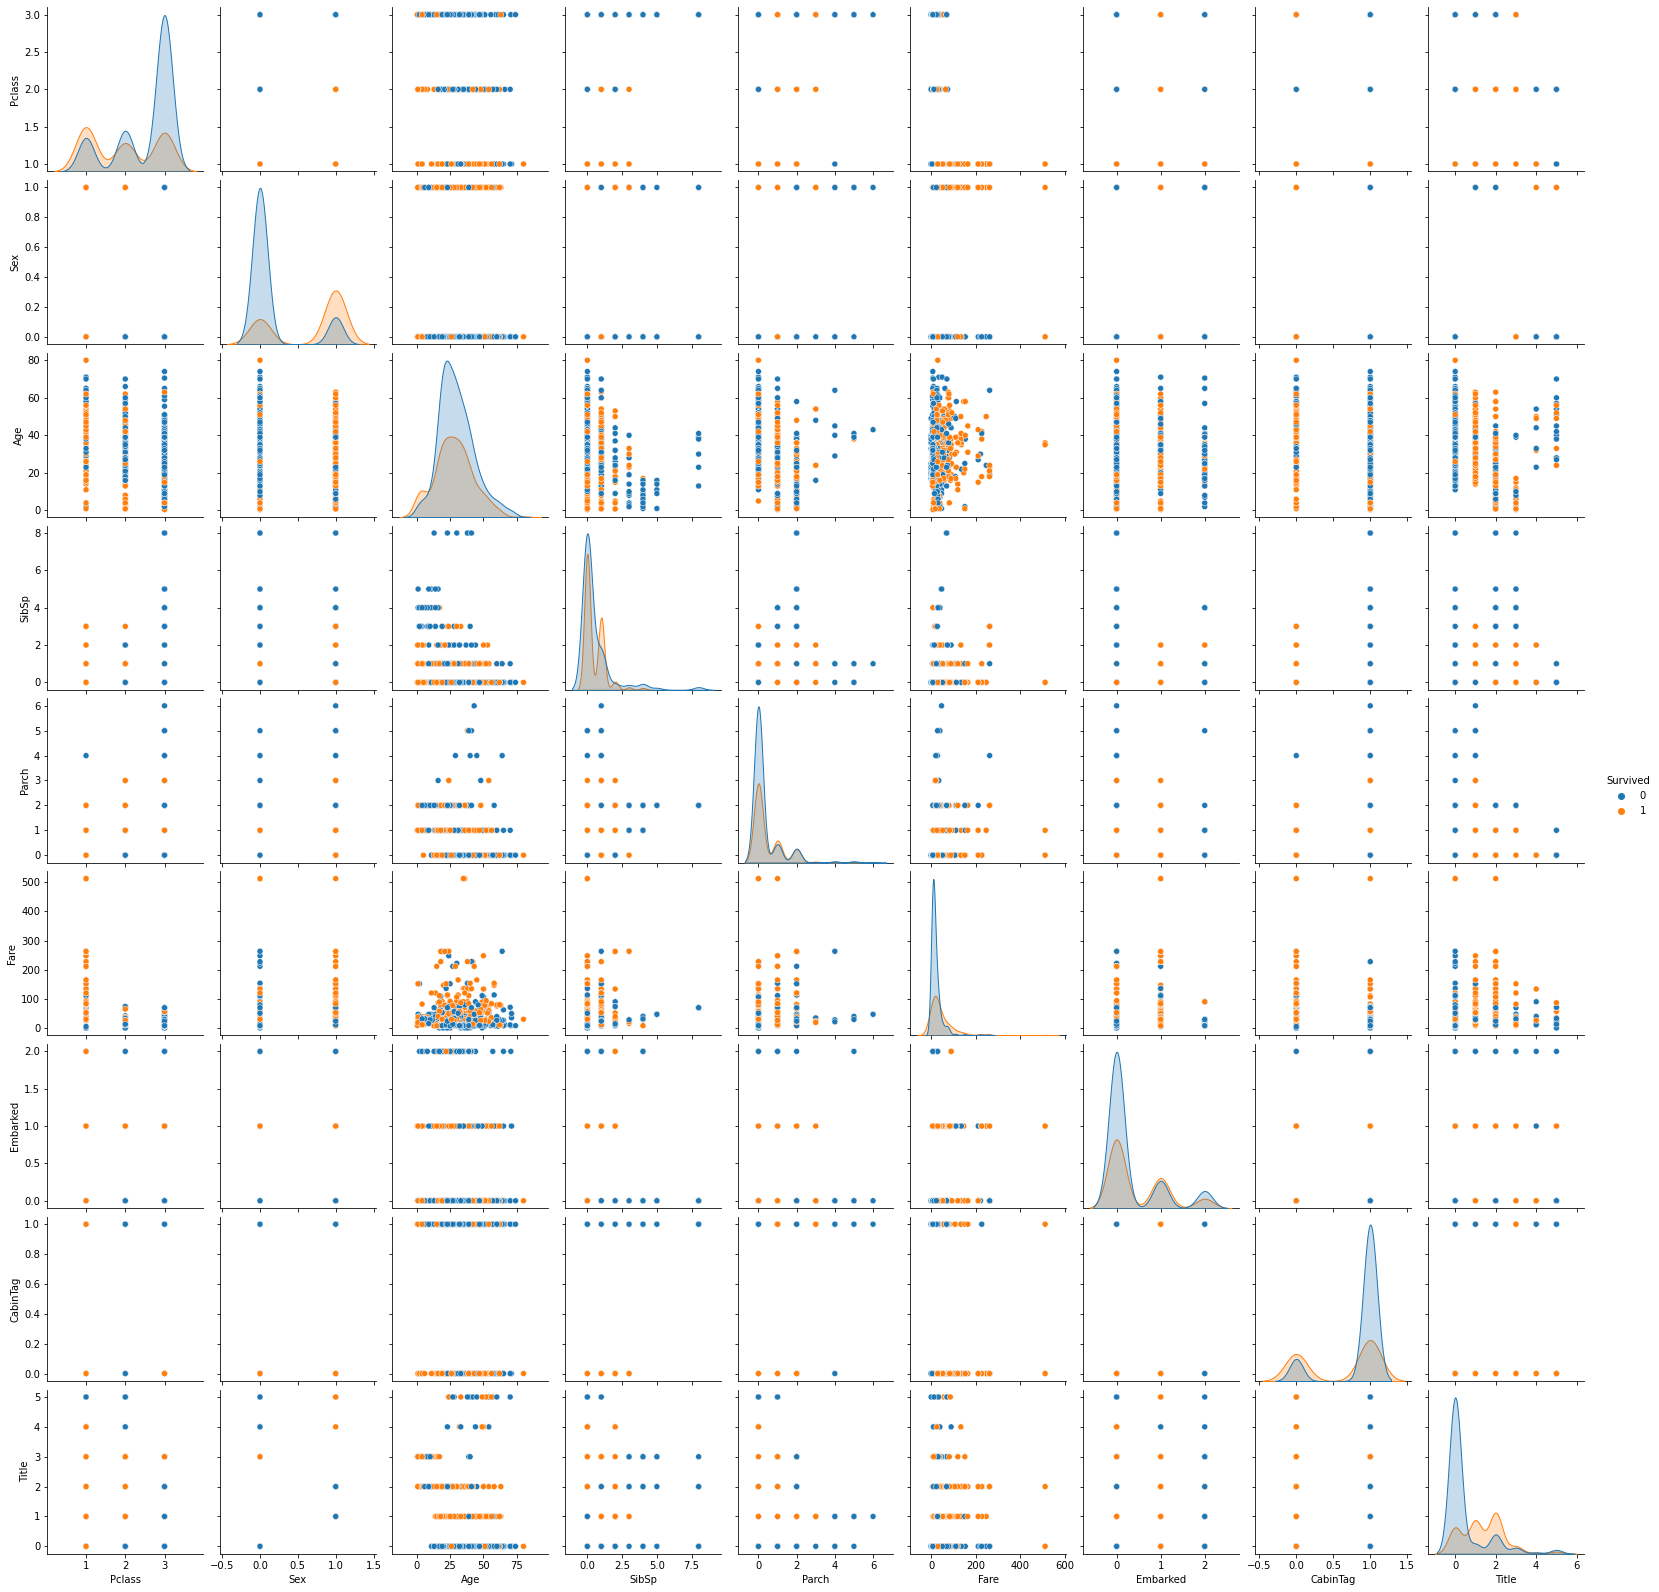

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train_data.drop('PassengerId', axis=1), hue='Survived')

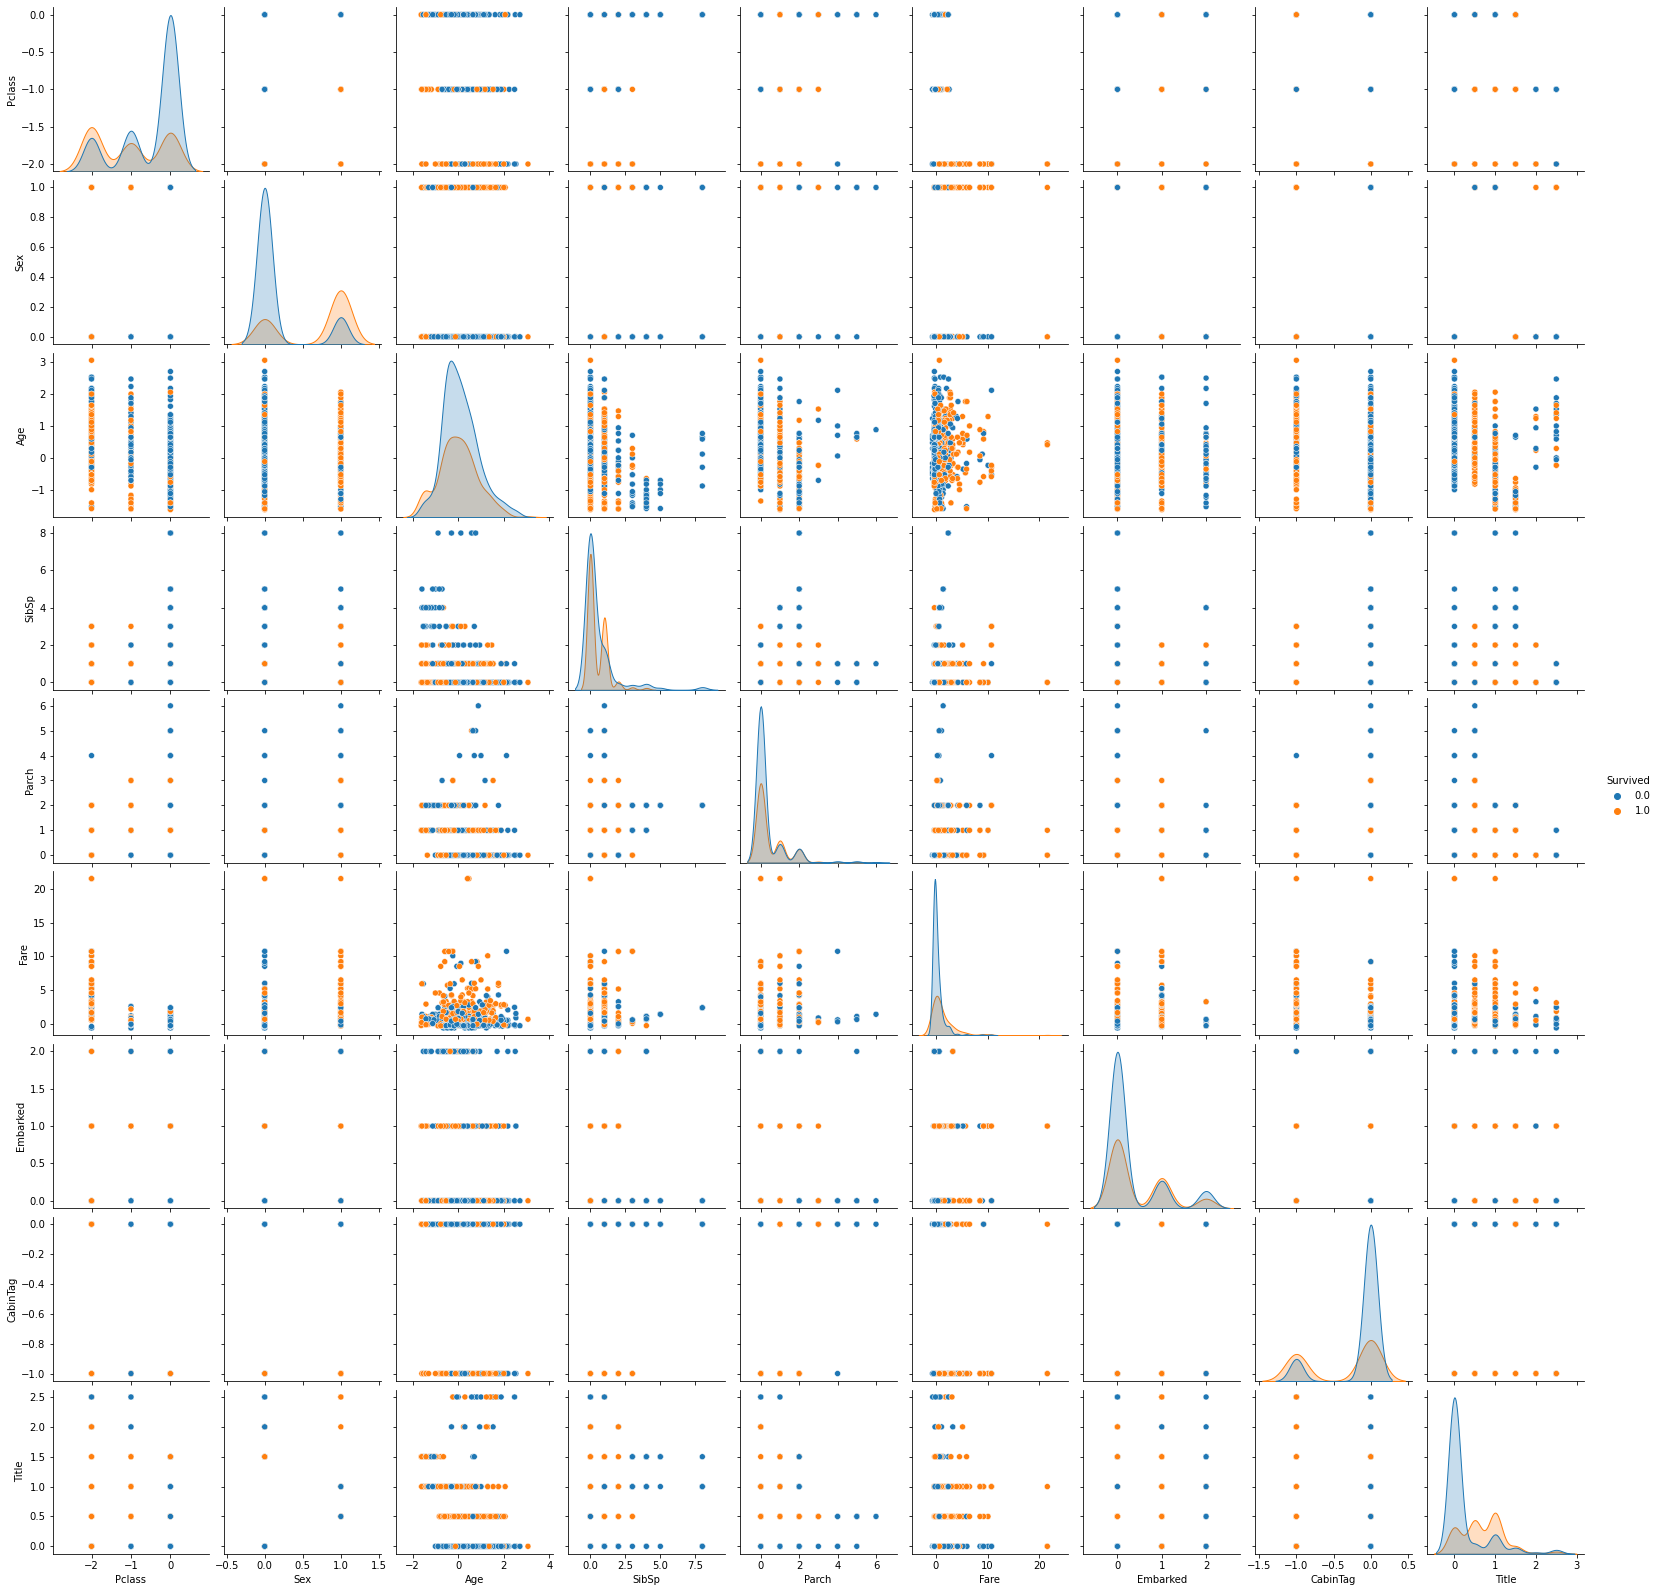

In [9]:
from sklearn.preprocessing import RobustScaler

X = data[0].drop(['PassengerId','Name','Cabin', 'Ticket'], axis=1)
scaler = RobustScaler()
scaler.fit(X.to_numpy())
df = scaler.transform(X.to_numpy())
df = pd.DataFrame(df, columns = list(X.columns))
    
sns.pairplot(df, hue='Survived')

<AxesSubplot:xlabel='CabinTag', ylabel='Count'>

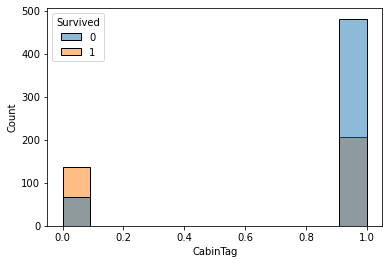

In [10]:
sns.histplot(train_data, x='CabinTag', hue='Survived')

Fare
Outliers: 53
...Winsorize column
[263.0, 146.5208, 263.0, 247.5208, 146.5208, 113.275, 512.3292, 153.4625, 135.6333, 151.55, 247.5208, 151.55, 110.8833, 108.9, 262.375, 164.8667, 134.5, 135.6333, 153.4625, 133.65, 134.5, 263.0, 135.6333, 211.5, 227.525, 120.0, 113.275, 120.0, 263.0, 151.55, 108.9, 221.7792, 106.425, 106.425, 110.8833, 227.525, 110.8833, 153.4625, 113.275, 133.65, 512.3292, 211.3375, 110.8833, 227.525, 151.55, 227.525, 211.3375, 512.3292, 262.375, 120.0, 211.3375, 120.0, 164.8667]


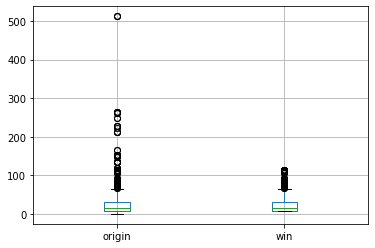

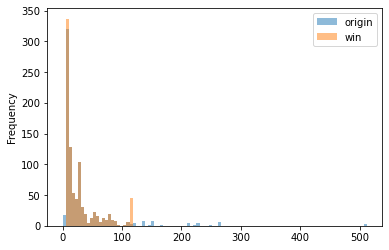

###
SibSp
Outliers: 12
...Winsorize column
[5, 5, 8, 8, 8, 8, 5, 5, 5, 8, 8, 8]


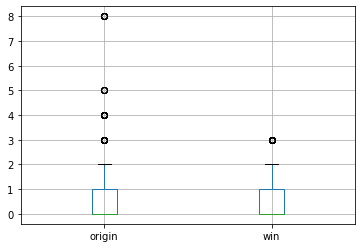

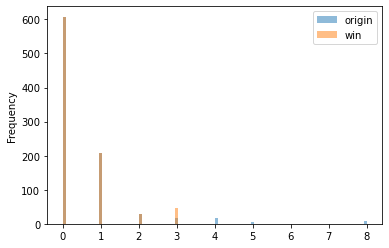

###
Parch
Outliers: 213
...Winsorize column
[1, 2, 1, 5, 1, 1, 5, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 4, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 3, 4, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 4, 1, 1, 2, 1, 2, 1, 1, 2, 5, 2, 1, 1, 1, 2, 1, 5, 2, 1, 1, 1, 2, 1, 6, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 5, 2]


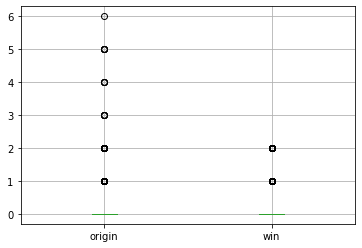

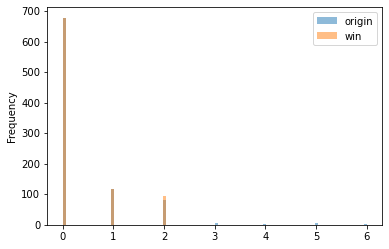

###


In [11]:
from sklearn.preprocessing import MinMaxScaler

X = train_data.drop(['PassengerId','Name','Cabin', 'Ticket'], axis=1)

k=3.
import scipy.stats.mstats as ssm
for col in ['Fare','Age','SibSp','Parch']:

    xslice = X[col].copy()

    q1 = xslice.quantile(0.25)
    q2 = xslice.quantile(0.75)
    iqr = q2 - q1
    lower = q1 - k*iqr 
    upper = q2 + k*iqr 

    outliers = [xs for xs in xslice if (xs < lower or xs > upper)]
    lo = len(outliers)
    if lo > 0:
        print(col)
        print(f'Outliers: {lo}')
        print('...Winsorize column')

        wslice = ssm.winsorize(xslice, (0.05, 0.05))
        d = {'origin': xslice.to_numpy(), 'win': wslice}
        print(outliers)

        df = pd.DataFrame(data=d)
        df.boxplot()
        plt.show()

        df.plot.hist(bins = 100, alpha=0.5)
        plt.show()

        X[col] = wslice
            
        print('###')

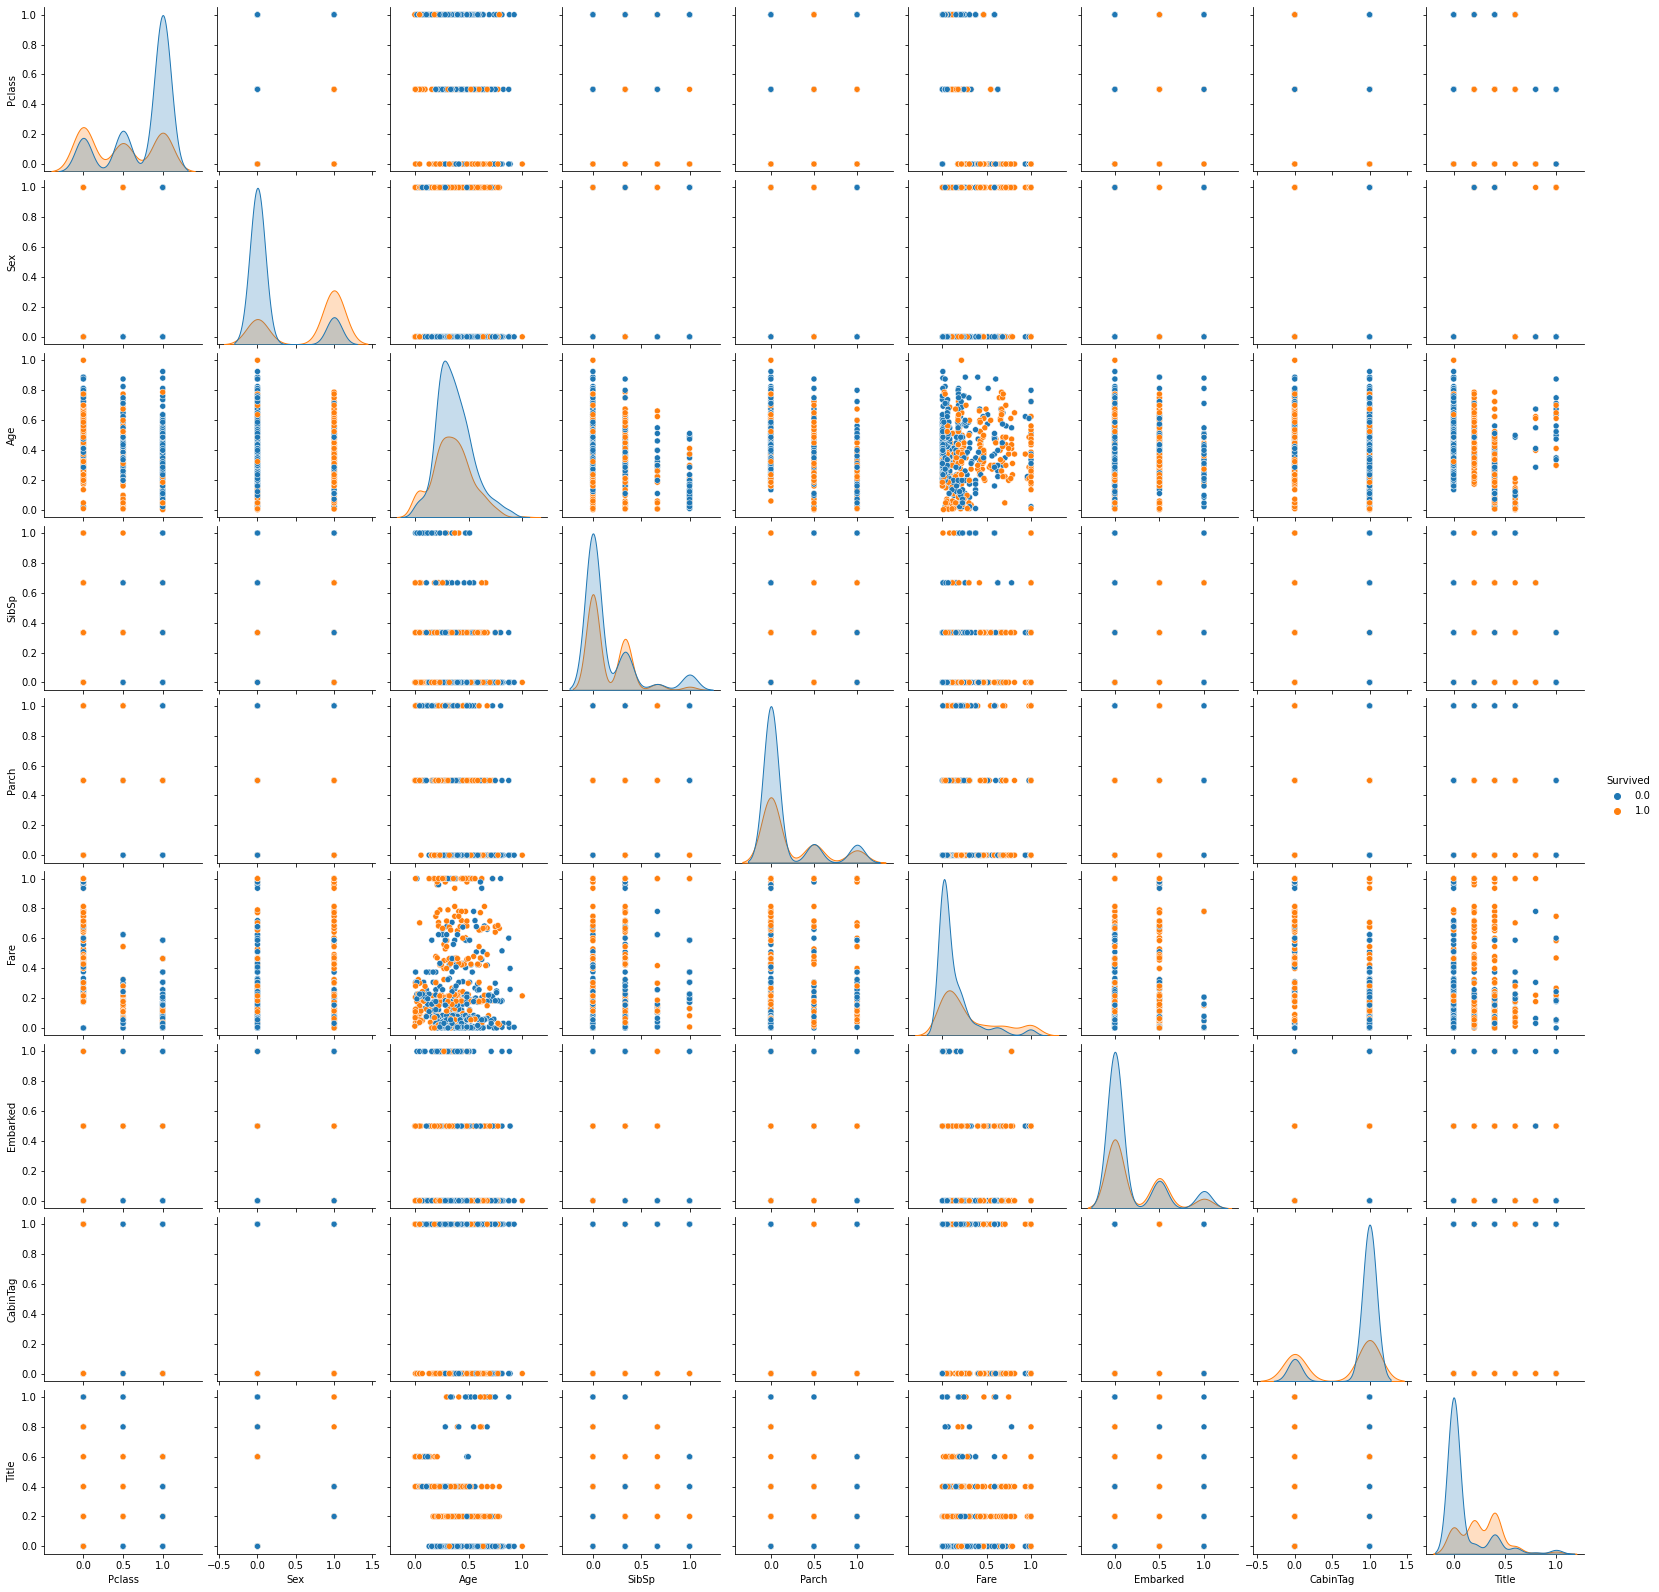

In [12]:
scaler = MinMaxScaler()
scaler.fit(X.to_numpy())
df = scaler.transform(X.to_numpy())
df = pd.DataFrame(df, columns = list(X.columns))
    
sns.pairplot(df, hue='Survived')

In [13]:
def addBucket(df, col, b=5.):
    
    bx = pd.cut(df[col], b, labels=False)
    df[col+'_group'] = bx/b

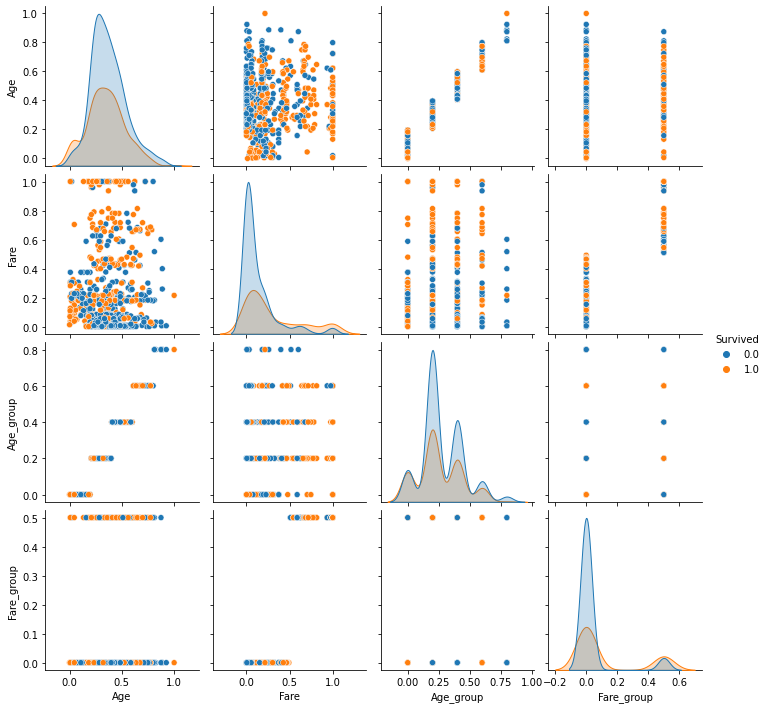

In [14]:
addBucket(df, 'Age',5)
addBucket(df, 'Fare',2)

sns.pairplot(df.drop(['Sex','Parch','SibSp','Title','Pclass','Embarked','CabinTag'],axis=1), hue='Survived')

In [15]:
y = train_data["Survived"]
y.to_csv(op.join(path,'train_label.csv'))

Z = df.drop( ['Survived', 'Age', 'Fare'] ,axis=1)
Z.to_csv(op.join(path,'train_RescaleClean.csv'))

Fare
Outliers: 31
...Winsorize column
[262.375, 263.0, 262.375, 262.375, 263.0, 211.5, 211.5, 221.7792, 221.7792, 151.55, 262.375, 221.7792, 247.5208, 134.5, 227.525, 164.8667, 211.5, 106.425, 134.5, 136.7792, 136.7792, 151.55, 135.6333, 146.5208, 211.3375, 512.3292, 134.5, 262.375, 164.8667, 211.5, 108.9]


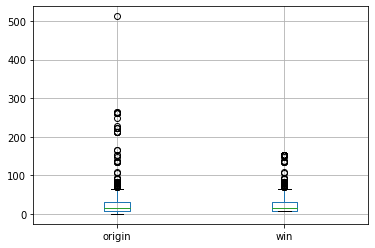

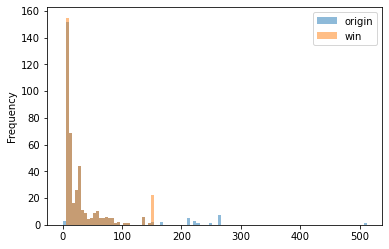

###
SibSp
Outliers: 3
...Winsorize column
[5, 8, 8]


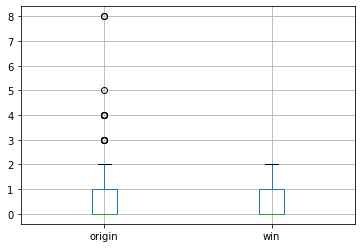

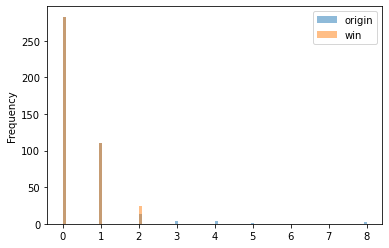

###
Parch
Outliers: 94
...Winsorize column
[1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 1, 2, 1, 2, 4, 1, 1, 2, 1, 1, 1, 4, 6, 2, 3, 1, 1, 2, 2, 2, 1, 1, 2, 5, 2, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 9, 1, 1, 1, 2, 2, 2, 1, 9, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1]


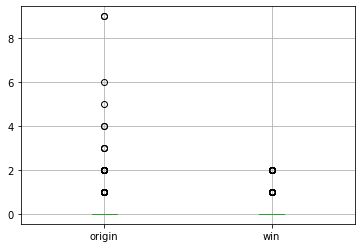

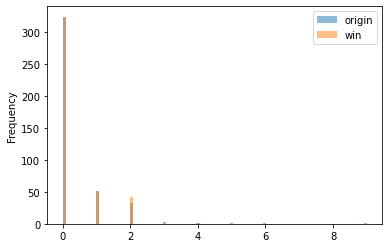

###


In [16]:
X_test = test_data.drop(['PassengerId','Name','Cabin', 'Ticket'], axis=1)

k=3.
for col in ['Fare','Age','SibSp','Parch']:

    xslice = X_test[col].copy()

    q1 = xslice.quantile(0.25)
    q2 = xslice.quantile(0.75)
    iqr = q2 - q1
    lower = q1 - k*iqr 
    upper = q2 + k*iqr 

    outliers = [xs for xs in xslice if (xs < lower or xs > upper)]
    lo = len(outliers)
    if lo > 0:
        print(col)
        print(f'Outliers: {lo}')
        print('...Winsorize column')

        wslice = ssm.winsorize(xslice, (0.05, 0.05))
        d = {'origin': xslice.to_numpy(), 'win': wslice}
        print(outliers)

        df = pd.DataFrame(data=d)
        df.boxplot()
        plt.show()

        df.plot.hist(bins = 100, alpha=0.5)
        plt.show()

        X_test[col] = wslice
            
        print('###')

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_test.to_numpy())
df = scaler.transform(X_test.to_numpy())
df = pd.DataFrame(df, columns = list(X_test.columns))

addBucket(df, 'Age',5)
addBucket(df, 'Fare',2)

Z_test = df.drop( ['Age', 'Fare'] ,axis=1)
# Z_test.to_csv(op.join(path,'test_RescaleClean.csv'))
Z_test.head()

,Pclass,Sex,SibSp,Parch,Embarked,CabinTag,Title,Age_group,Fare_group
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.4,0.0
1,1.0,1.0,0.5,0.0,0.0,1.0,0.2,0.6,0.0
2,0.5,0.0,0.0,0.0,1.0,1.0,0.0,0.8,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.0
4,1.0,1.0,0.5,0.5,0.0,1.0,0.2,0.2,0.0
